# 쇼핑몰 지점별 매출액 

## features
- id : 샘플 아이디
- Store : 쇼핑몰 지점 (어디 지역인지는 알 수 없음)
- Date : 주 단위(Weekly) 날짜
- Temperature : 해당 쇼핑몰 주변 기온
- Fuel_Price : 해당 쇼핑몰 주변 연료 가격
- Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
- Unemployment : 해당 쇼핑몰 지역의 실업률
- IsHoliday : 해당 기간의 공휴일 포함 여부
- Weekly_Sales : 주간 매출액 (목표 예측값)

## 분석 전 예상
1. 주변 평균 기온이 적당(섭씨 10~26도)한 주는 그렇지 않을 때보다 같은 쇼핑몰에서의 주간 매출액이 높았을 것이다 (매출액 상위 10개 지점)
2. 프로모션 수치가 높을 수록 주간 매출액은 높을 것이다 - (비식별화된 프로모션 정보이므로 시각화를 통해 매출과의 연관성 분석)
3. 해당 쇼핑몰의 주변 연료 가격과 주간 매출액과의 연관성은 낮을 것이다 <-> 연료가격이 높아지는 것은 물가가 증가하는 것이므로 전체로 봤을 때 연료 가격이 증가하면 매출액이 적을 것으로 보임(체크)
4. 쇼핑몰 간에 지역의 실업률이 높을수록 매출액이 더 낮을 것이다
<!-- 5. 해당 기간의 공휴일이 있을 경우엔 같은 쇼핑몰일 때 주간 매출액이 높을 것이다 -->

In [1]:
import pandas as pd
import numpy as np

from scipy.interpolate import make_interp_spline
from plotly.subplots import make_subplots as ms
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly

from datetime import datetime

import os

In [3]:
file_dir = './data'
file_name = os.path.join(file_dir, 'train.csv')

shop_df = pd.read_csv(file_name).set_index('id')

### 1. 평균 기온이 적당한 주는 그렇지 않을 때보다 지점이 같은 쇼핑몰에서의 주간 매출액이 높았을 것이다.

온도 범위를 18도 이하 24도 이상 3구간으로 나눠서 분류를 한 column추가

In [48]:
shop_df['Celcius_temp'] = shop_df['Temperature'].apply(
    lambda x: 'under_10' if ((x-32)/1.8) < 10
                         else ('over_26' if ((x-32)/1.8) > 26 else 'good_temp')
)

shop_df['Fuel_Price'] = shop_df['Fuel_Price'].apply(
    lambda x: round(x,2)
)

shop_df['Celcius_degree'] = shop_df['Temperature'].apply(lambda x: round(((x-32)/1.8), 0))


shop_df.tail()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Celcius_temp,Month_Year,Celcius_degree
id,,,,,,,,,,,,,,,
6251,45,2012-08-31,75.09,3.87,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87,good_temp,2012-08,24.0
6252,45,2012-09-07,75.70,3.91,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66,good_temp,2012-09,24.0
6253,45,2012-09-14,67.87,3.95,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27,good_temp,2012-09,20.0
6254,45,2012-09-21,65.32,4.04,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20,good_temp,2012-09,19.0
6255,45,2012-09-28,64.88,4.00,4556.61,20.64,1.50,1601.01,3288.25,8.684,False,713173.95,good_temp,2012-09,18.0


In [5]:
top_rank_store_list = shop_df.groupby('Store').mean()['Weekly_Sales'].sort_values()[::-1][:20].index
top_rank_store_df = pd.DataFrame()

for store_number in top_rank_store_list:
    top_rank_store_df = pd.concat([top_rank_store_df, shop_df.loc[shop_df['Store'] == store_number]])
top_rank_store_df.head()    

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Celcius_temp
id,,,,,,,,,,,,,
2642,20,05/02/2010,25.92,2.78,NaN,NaN,NaN,NaN,NaN,8.187,False,2401395.47,under_10
2643,20,12/02/2010,22.12,2.77,NaN,NaN,NaN,NaN,NaN,8.187,True,2109107.90,under_10
2644,20,19/02/2010,25.43,2.75,NaN,NaN,NaN,NaN,NaN,8.187,False,2161549.76,under_10
2645,20,26/02/2010,32.32,2.75,NaN,NaN,NaN,NaN,NaN,8.187,False,1898193.95,under_10
2646,20,05/03/2010,31.75,2.78,NaN,NaN,NaN,NaN,NaN,8.187,False,2119213.72,under_10


In [6]:
temp_df = top_rank_store_df.groupby(['Store', 'Celcius_temp']).mean().reset_index()
temp_df.head()

,Store,Celcius_temp,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,good_temp,66.427808,3.305068,8393.630690,1209.863913,2007.552759,3505.890000,4764.298621,7.595918,0.054795,1.563798e+06
1,1,over_26,84.088140,3.180465,10149.685000,170.924000,35.417778,5850.530000,3971.286000,7.635023,0.023256,1.514623e+06
2,1,under_10,44.964348,2.960000,6752.086250,11745.923750,336.871250,3189.626250,8112.928750,7.790870,0.217391,1.603095e+06
3,2,good_temp,65.316087,3.317246,12253.607308,2804.275500,3101.040000,4681.000769,5629.933846,7.626507,0.043478,1.897005e+06
4,2,over_26,85.414783,3.179348,10546.937692,209.468462,30.028333,6319.684615,7248.367692,7.624043,0.043478,1.874508e+06


In [ ]:
plt.figure(figsize=(20, 10))
plt.title('상위 20개 상점의 기온에 따른 거래량')
sns.barplot(data = temp_df, x='Store', y='Weekly_Sales', hue= 'Celcius_temp')
plt.show()

> 기온이 적당하다고 해서 거래량에 직접적인 영향을 준다고 하기엔 어려워보임. -> 계절별 시계열 그래프 찍어서 패턴 찾는 것도 좋아보임  
> 10년 2월부터 12년 9월까지 있으므로 봄은 3~5월, 여름은 6~8월, 가을은 9월~11월 겨울은 12월~2월까지로 함

In [7]:
shop_df['Date'] = shop_df['Date'].apply(lambda x: '-'.join([x.split('/')[1],x.split('/')[0],x.split('/')[2]]))

In [8]:
shop_df['Date'] = shop_df['Date'].astype({'Date' : 'datetime64'})
shop_df.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Celcius_temp
id,,,,,,,,,,,,,
1,1,2010-02-05,42.31,2.57,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90,under_10
2,1,2010-02-12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44,under_10
3,1,2010-02-19,39.93,2.51,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17,under_10
4,1,2010-02-26,46.63,2.56,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59,under_10
5,1,2010-03-05,46.50,2.62,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68,under_10


In [31]:
shop_df['Month_Year'] = shop_df["Date"].apply(lambda x: x.strftime('%Y-%m'))

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Celcius_temp,Month_Year
id,,,,,,,,,,,,,,
6251,45,2012-08-31,75.09,3.87,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87,good_temp,2012-08
6252,45,2012-09-07,75.70,3.91,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66,good_temp,2012-09
6253,45,2012-09-14,67.87,3.95,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27,good_temp,2012-09
6254,45,2012-09-21,65.32,4.04,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20,good_temp,2012-09
6255,45,2012-09-28,64.88,4.00,4556.61,20.64,1.50,1601.01,3288.25,8.684,False,713173.95,good_temp,2012-09


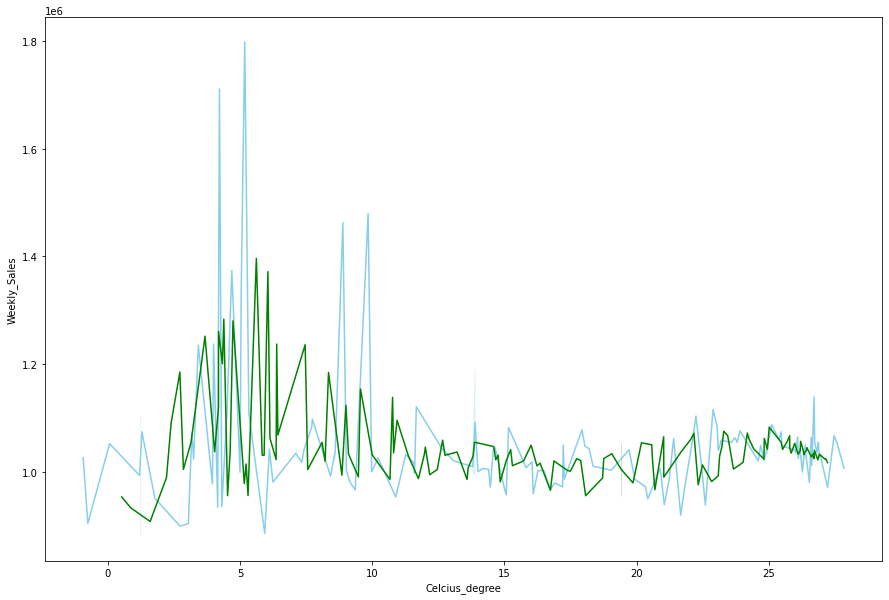

In [165]:
plt.figure(figsize=(15, 10))

# sns.regplot(
#     data=shop_df.groupby('Date').mean(), x='Celcius_degree', y="Weekly_Sales", lowess=True, color = 'gray'
# )

sns.lineplot(
    data=shop_df.groupby('Date').mean(), x='Celcius_degree', y="Weekly_Sales", color = 'skyblue'
)

sns.lineplot(
    data=shop_df.groupby('Date').mean().rolling(window=5).mean(), x='Celcius_degree', y="Weekly_Sales", color = 'green'
)

plt.show()

In [53]:
fig = go.Figure()    
# fig = ms(specs=[[{'secondary_y': True}]])

fig.add_trace(go.Scatter(x = shop_df.groupby('Date').mean().index, 
                        y = shop_df.groupby('Date').mean()['Weekly_Sales'],
                        mode='lines', 
                        name='Weekly_Sales',)
                        
)

quarter = ['03','06','09','12']
color = ['green', 'red', 'yellow', 'white']
for i in range(len(quarter)):    
    fig.add_shape(type = 'line', x0 = f'2010-{quarter[i]}-01', y0 = 0, x1 = f'2010-{quarter[i]}-01', y1 =1, xref='x', yref='paper',
                  line = {'color' : 'green'})
    fig.add_shape(type = 'rect', x0 = f'2010-{quarter[i]}-01', y0 = 0, x1 = f'2010-{quarter[0] if i//3 == 1 else quarter[i+1]}-01', y1 =1, 
              fillcolor = color[i],opacity = 0.1, line = {'width' : 0}, xref='x',yref='paper')
    
    fig.add_shape(type = 'line', x0 = f'2011-{quarter[i]}-01', y0 = 0, x1 = f'2011-{quarter[i]}-01', y1 =1, xref='x', yref='paper',
                  line = {'color' : 'green'})
    fig.add_shape(type = 'rect', x0 = f'2011-{quarter[i]}-01', y0 = 0, x1 = f'2011-{quarter[0] if i//3 == 1 else quarter[i+1]}-01', y1 =1, 
              fillcolor = color[i],opacity = 0.1, line = {'width' : 0}, xref='x',yref='paper')

    fig.add_shape(type = 'line', x0 = f'2012-{quarter[i]}-01', y0 = 0, x1 = f'2012-{quarter[i]}-01', y1 =1, xref='x', yref='paper',
                  line = {'color' : 'green'})
    fig.add_shape(type = 'rect', x0 = f'2012-{quarter[i]}-01', y0 = 0, x1 = f'2012-{quarter[0] if i//3 == 1 else quarter[i+1]}-01', y1 =1, 
              fillcolor = color[i],opacity = 0.1, line = {'width' : 0}, xref='x',yref='paper')
fig.show()                  

### 2. 프로모션 수치가 높을 수록 주간 매출액은 높을 것이다

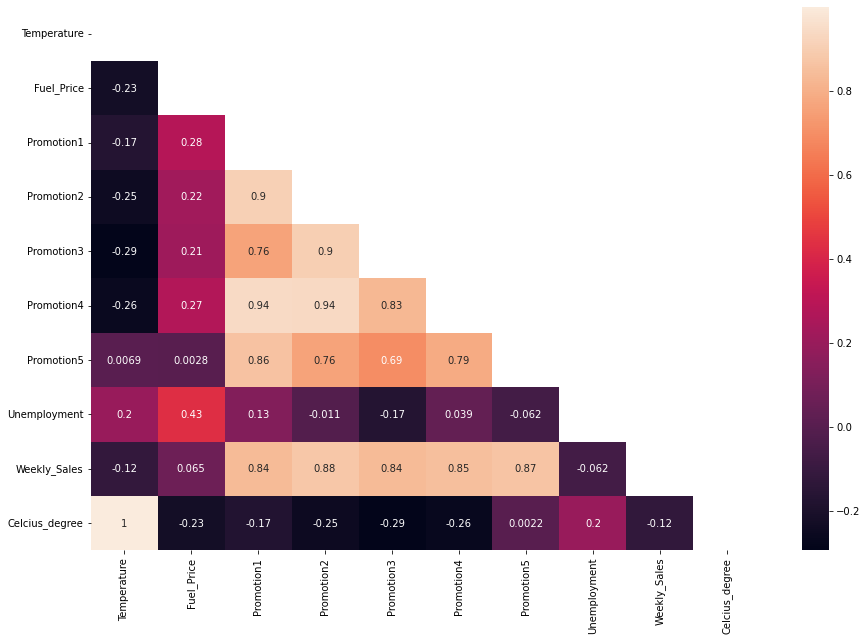

In [54]:
plt.figure(figsize=(15, 10))
corr = sns.heatmap(shop_df.groupby('Store').mean().drop(columns='IsHoliday').corr(method= "spearman"), annot=True, mask = np.triu(shop_df.groupby('Store').mean().drop(columns='IsHoliday').corr(method= "spearman")))
plt.show()

In [55]:
for i in range(5):
    shop_df[f'Promotion{i+1}'] = shop_df[f'Promotion{i+1}'].fillna(0)
shop_df['sum_of_promotion'] = shop_df[['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5']].sum(axis = 1)

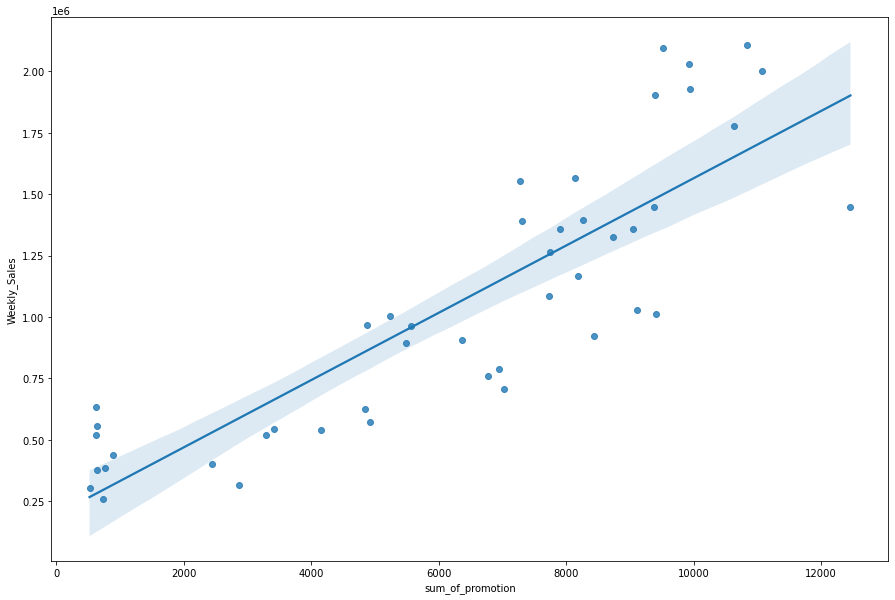

In [82]:
plt.figure(figsize=(15, 10))

sns.regplot(
    data=shop_df.groupby('Store').mean(), x='sum_of_promotion', y="Weekly_Sales",        
)

plt.show()

In [83]:
fig = ms(specs=[[{'secondary_y': True}]])

fig.add_trace(go.Scatter(x = shop_df.groupby('Date').mean().index, 
                        y = shop_df.groupby('Date').mean()['Weekly_Sales'],
                        mode='lines', 
                        name='Weekly_Sales',), secondary_y = False
)

fig.add_trace(go.Scatter(x = shop_df.groupby('Date').mean().index, 
                        y = shop_df.groupby('Date').mean()['sum_of_promotion'],
                        mode='lines', 
                        name='sum_of_promotion',), secondary_y = True
)

fig.show() 

> 전체 상점 프로모션의 합의 평균과 주간 판매량의 평균은 상당한 선형관계를 가지고 있는 것으로 보아 높은 관련성이 있는 것을 그래프로 확인 가능

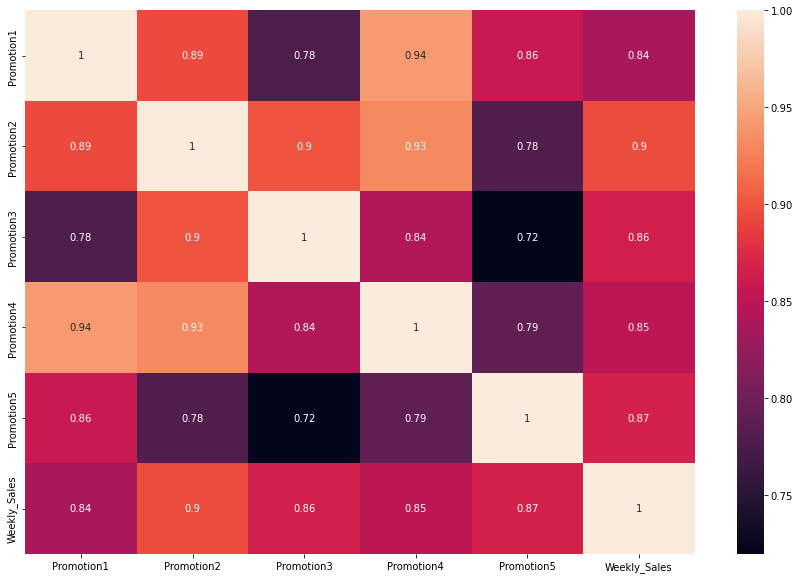

In [166]:
plt.figure(figsize=(15, 10))
corr = sns.heatmap(shop_df.groupby('Store').mean()[['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5', 'Weekly_Sales']].corr(method= "spearman"), annot=True), #mask = np.triu(shop_df.groupby('Store').mean().drop(columns='IsHoliday').corr(method= "spearman")))
plt.show()

### 3. 해당 쇼핑몰의 주변 연료 가격과 주간 매출액과의 연관성은 낮을 것이다 <-> 연료가격이 높아지는 것은 물가가 증가하는 것이므로 전체로 봤을 때 연료 가격이 증가하면 매출액이 적을 것으로 보임

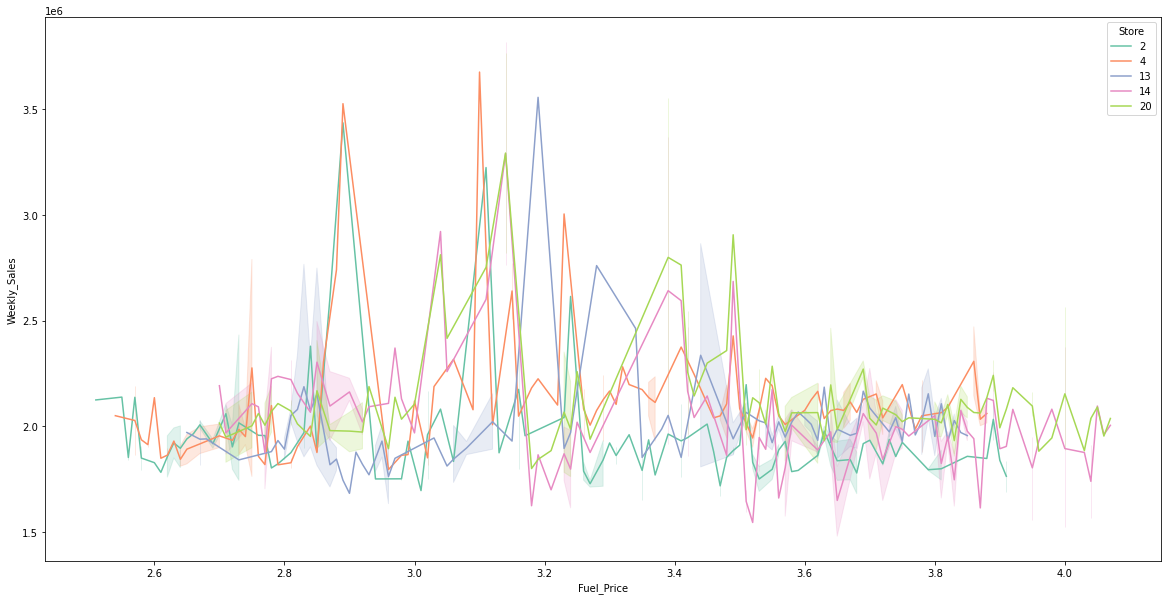

In [84]:
top_rank_5_store_list = shop_df.groupby('Store').mean()['Weekly_Sales'].sort_values()[::-1][:5].index
top_rank_5_store_df = pd.DataFrame()

for store_number in top_rank_5_store_list:
    top_rank_5_store_df = pd.concat([top_rank_5_store_df, shop_df.loc[shop_df['Store'] == store_number]])


plt.figure(figsize=(20, 10))

sns.lineplot(
    data=top_rank_5_store_df, x="Fuel_Price", y="Weekly_Sales",
    hue="Store", palette='Set2'
)
plt.show()

/usr/local/Caskroom/miniconda/base/envs/da/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



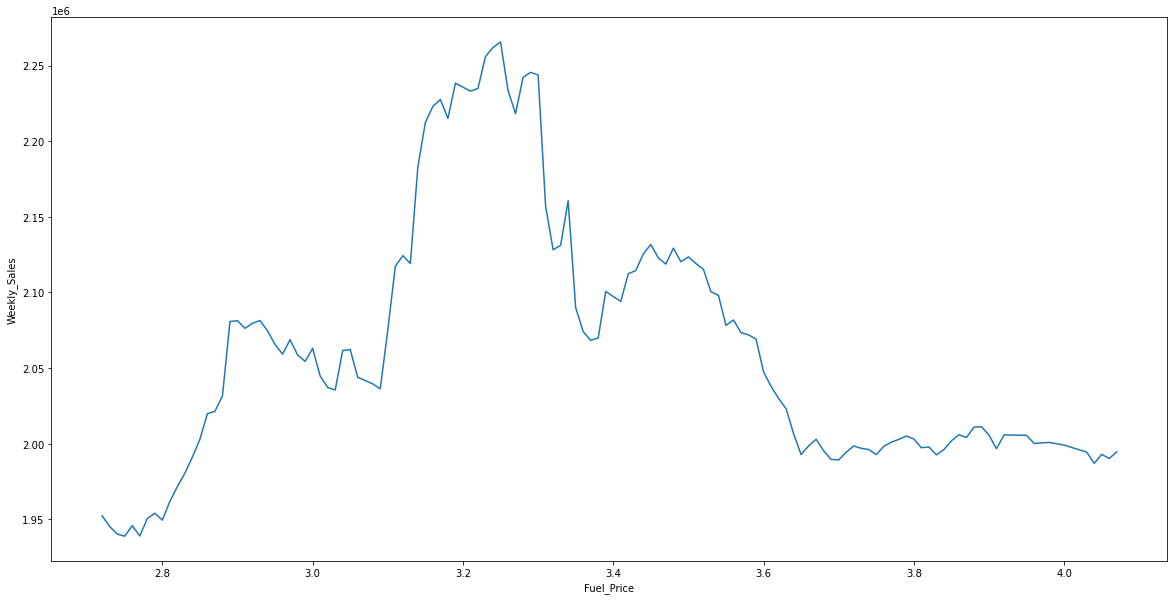

In [173]:
plt.figure(figsize=(20, 10))
sns.lineplot(top_rank_5_store_df.groupby('Fuel_Price').mean().rolling(window = 20).mean().index, top_rank_5_store_df.groupby('Fuel_Price').mean().rolling(window = 20).mean()['Weekly_Sales'])
plt.show()

> 기름가격과 판매량 사이의 관계는 크게 없어보이나 그래프가 많이 겹치는 것을 보아 특정 위치에 상관관계가 있어보임, 다만 기름값이 중간을 기점으로 크게 상승할 때엔 전체적으로 Sales_Price가 줄어든 것을 볼 수 있음

<AxesSubplot:>

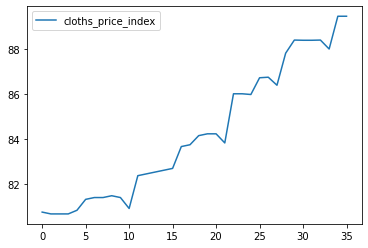

In [109]:
cloths_price_index_df = pd.read_csv('./data/소비자물가지수_27160010.csv')
cloths_price_index_df = cloths_price_index_df.T
cloths_price_index_df = cloths_price_index_df.drop(labels=['통계표', '계정항목', '단위', '가중치', '변환'], axis=0).reset_index()
cloths_price_index_df = cloths_price_index_df.rename(columns={'index' : 'Month_Year', 0 : 'cloths_price_index'})
cloths_price_index_df['Month_Year'] = cloths_price_index_df['Month_Year'].apply(lambda x: x.replace('/', '-'))
cloths_price_index_df.plot()

<AxesSubplot:>

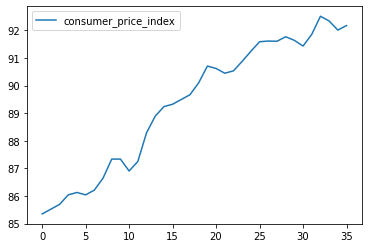

In [101]:
consumer_price_index_df = pd.read_csv('./data/소비자물가지수_27150352.csv')
consumer_price_index_df = consumer_price_index_df.T.drop(labels=['통계표', '계정항목', '단위', '가중치', '변환'], axis=0).reset_index()
consumer_price_index_df = consumer_price_index_df.rename(columns={'index' : 'Month_Year', 0 : 'consumer_price_index'})
consumer_price_index_df['Month_Year'] = consumer_price_index_df['Month_Year'].apply(lambda x: x.replace('/', '-'))
consumer_price_index_df.plot()

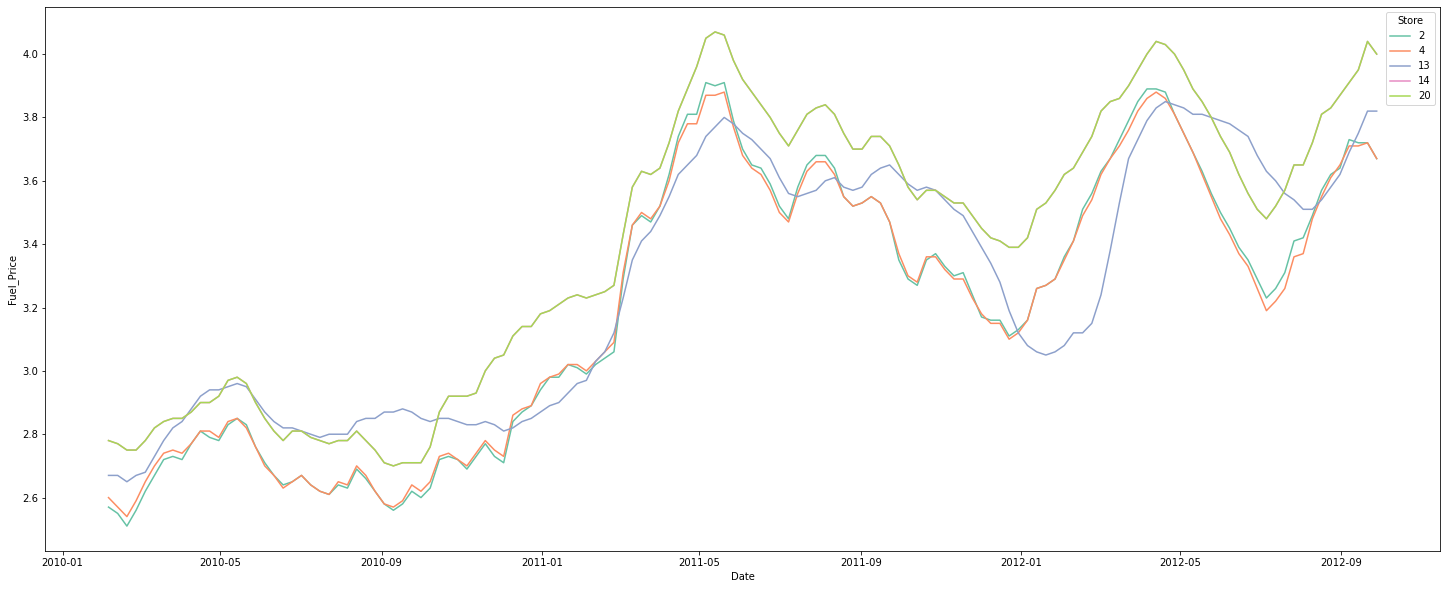

In [102]:
plt.figure(figsize=(25, 10))

sns.lineplot(
    data=top_rank_5_store_df, x="Date", y="Fuel_Price",
    hue="Store", palette='Set2', 
)

plt.show()

In [146]:
index_fig = ms(specs=[[{'secondary_y': True}]])

index_fig.add_trace(go.Scatter(x = top_rank_5_store_df.groupby('Month_Year').mean().rolling(window=3).mean().fillna(0).index, 
                        y = top_rank_5_store_df.groupby('Month_Year').mean().rolling(window=3).mean().fillna(0)['Fuel_Price'],
                        mode='lines', 
                        name='Fuel_Price',), secondary_y = False
)

index_fig.add_trace(go.Scatter(x = cloths_price_index_df['Month_Year'], 
                        y = cloths_price_index_df['cloths_price_index'],
                        mode='lines', 
                        name='cloths_price_index',), secondary_y = True
)

index_fig.show()

### 4. 쇼핑몰 간 지역 실업률이 높을수록 매출액이 더 낮을 것이다

In [103]:
for store_num in top_rank_5_store_list:
    # globals()[f'fig_{store_num}'] = go.Figure()    
    globals()[f'fig_{store_num}'] = ms(specs=[[{'secondary_y': True}]])
    
    store_holiday_list = top_rank_5_store_df[(top_rank_5_store_df['IsHoliday'] == True) & (top_rank_5_store_df['Store']== store_num)]['Date'].tolist()
    for i in store_holiday_list:
        # print(i)
        globals()[f'fig_{store_num}'].add_shape(type = 'line', x0 = f'{i}', y0 = 0, x1 = f'{i}', y1 =1, xref='x', yref='paper',
                      line = {'color' : 'green'})
    
    globals()[f'fig_{store_num}'].add_trace(go.Scatter(x = shop_df[shop_df['Store'] == store_num]['Date'], 
                            y = shop_df[shop_df['Store'] == store_num]['Unemployment'],
                            mode='lines', 
                            name=f'Unemployment_of_{store_num}',), secondary_y = False
                            
    )

    globals()[f'fig_{store_num}'].add_trace(go.Scatter(x = shop_df[shop_df['Store'] == store_num]['Date'], 
                            y = shop_df[shop_df['Store'] == store_num]['Weekly_Sales'],
                            mode='lines', 
                            name=f'Weekly_Sales_{store_num}'),secondary_y = True
    )
    

    
    

fig_13.show()
fig_20.show()
fig_14.show()
fig_2.show()
fig_4.show()

> 연관이 없는걸로 보임 하지만 5개의 상점 모두 특정 시기에 판매량이 급증하고 급감하는데 이를 알아볼 필요가 있어보임
- 크리스마스 시즌에 매출이 급증하고 연초에 급감
- 11월 수능시즌에 급증

holiday 찍어보기

공휴일 프로모션 가격 상관성 찍어보기

In [167]:
corr_df = shop_df.drop(columns=['Store', 'Fuel_Price', 'Temperature'])
corr_df = pd.get_dummies(corr_df, columns = ['IsHoliday', 'Celcius_temp'])

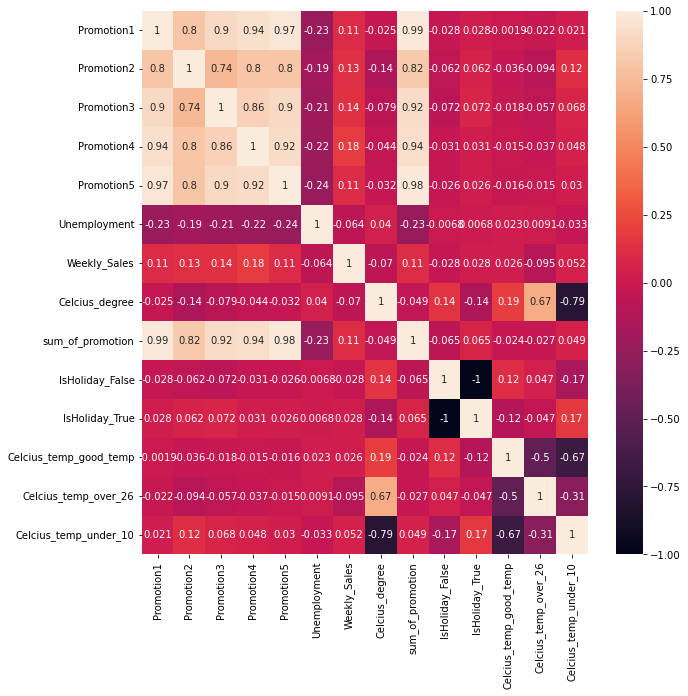

In [168]:
plt.figure(figsize=(10, 10))
corr = sns.heatmap(corr_df.corr(method= "spearman"), annot=True)
plt.show()